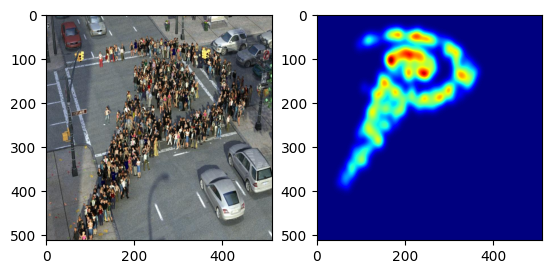

In [1]:
import os
import glob
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import h5py

def load_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (512, 512))
    img = img.astype(np.float32) / 255.0
    img_tensor = torch.from_numpy(img).permute(2, 0, 1)
    return img_tensor

def load_density_map(h5_path):
    with h5py.File(h5_path, 'r') as f:
        density = np.array(f['density'])
    density = cv2.resize(density, (512, 512))
    density_tensor = torch.from_numpy(density).unsqueeze(0).float()
    return density_tensor

class CrowdDataset(Dataset):
    def __init__(self, root_path):
        self.img_paths = glob.glob(os.path.join(root_path, "images", "*.jpg"))
        self.gt_paths = [os.path.join(root_path, "ground-truth-h5", "GT_" + os.path.basename(p).replace(".jpg", ".h5")) for p in self.img_paths]

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img = load_image(self.img_paths[idx])
        density = load_density_map(self.gt_paths[idx])
        return img, density

train_path = r"D:\Task For Infosys Internship\archive\ShanghaiTech\part_A\train_data"
test_path = r"D:\Task For Infosys Internship\archive\ShanghaiTech\part_A\test_data"

train_dataset = CrowdDataset(train_path)
test_dataset = CrowdDataset(test_path)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

imgs, densities = next(iter(train_loader))
plt.subplot(1, 2, 1)
plt.imshow(imgs[0].permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(densities[0][0], cmap="jet")
plt.savefig("sample_visualization.png")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.08956].


Image Batch Shape: torch.Size([4, 3, 512, 512])
Density Batch Shape: torch.Size([4, 1, 512, 512])


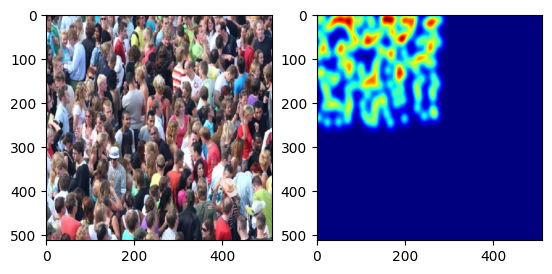

In [49]:
import os
import glob
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import h5py
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def load_image(img_path):
    img = Image.open(img_path).convert("RGB")
    return transform(img)

def load_density_map(h5_path):
    with h5py.File(h5_path, "r") as hf:
        density = np.array(hf["density"])
    density = cv2.resize(density, (512, 512))
    if density.sum() > 0:
        density = density * (density.sum() / density.sum()) 
    density_tensor = torch.from_numpy(density).unsqueeze(0).float()
    return density_tensor

class CrowdDataset(Dataset):
    def __init__(self, root_path):
        self.img_paths = glob.glob(os.path.join(root_path, "images", "*.jpg"))
        self.gt_paths = [os.path.join(root_path, "ground-truth-h5", "GT_" + os.path.basename(p).replace(".jpg", ".h5")) for p in self.img_paths]

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img = load_image(self.img_paths[idx])
        density = load_density_map(self.gt_paths[idx])
        return img, density

if __name__ == "__main__":
    train_path = r"D:\Task For Infosys Internship\archive\ShanghaiTech\part_A\train_data"
    test_path = r"D:\Task For Infosys Internship\archive\ShanghaiTech\part_A\test_data"

    train_dataset = CrowdDataset(train_path)
    test_dataset = CrowdDataset(test_path)

    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

    imgs, densities = next(iter(train_loader))


    plt.subplot(1, 2, 1)
    plt.imshow(imgs[0].permute(1, 2, 0).numpy() * 0.229 + 0.485)
    plt.subplot(1, 2, 2)
    plt.imshow(densities[0][0], cmap="jet")
    plt.savefig("sample_visualization.png")
    print(f"Image Batch Shape: {imgs.shape}")
    print(f"Density Batch Shape: {densities.shape}")
